<a href="https://www.kaggle.com/code/aleksandrmorozov123/deep-learning-for-nlp-and-cv?scriptVersionId=169195395" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lfwpeople/pairsDevTrain.txt
/kaggle/input/lfwpeople/lfw-funneled.tgz
/kaggle/input/lfwpeople/pairsDevTest.txt
/kaggle/input/lfwpeople/pairs.txt
/kaggle/input/massive-stock-news-analysis-db-for-nlpbacktests/analyst_ratings_processed.csv
/kaggle/input/massive-stock-news-analysis-db-for-nlpbacktests/raw_analyst_ratings.csv
/kaggle/input/massive-stock-news-analysis-db-for-nlpbacktests/raw_partner_headlines.csv


**Checking statistics of the Corpus**

In [2]:
# import required libraries
import pandas as pd

# we get first 10 000 values for fast running
ratings = pd.read_csv ('/kaggle/input/massive-stock-news-analysis-db-for-nlpbacktests/raw_analyst_ratings.csv')[0:10000]
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  10000 non-null  int64 
 1   headline    10000 non-null  object
 2   url         10000 non-null  object
 3   publisher   10000 non-null  object
 4   date        10000 non-null  object
 5   stock       10000 non-null  object
dtypes: int64(1), object(5)
memory usage: 468.9+ KB


In [3]:
# comparing the text of two selected ratings
print (repr(ratings.iloc[3399]['headline'][0:300]))
print (repr(ratings.iloc[5487]['headline'][0:300]))

'Goldman Sachs Upgrades Alcoa To Buy, Raises Price Target (AA)'
"45 Stocks Moving In Thursday's Mid-Day Session"


In [4]:
# ignore spaces after the stop words
import re
ratings ["paragraphs"] = ratings ["headline"].map (lambda text: re.split ('[.?!]\s*\n', text))
ratings ['number_of_paragraphs'] = ratings ["paragraphs"].map (len)

**Preparations**

In [5]:
# import required libraries
import sklearn
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.de.stop_words import STOP_WORDS

tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(STOP_WORDS))
vectors_text = tfidf_text_vectorizer.fit_transform (ratings ['headline'])
vectors_text.shape

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


(10000, 10390)

In [6]:
# flatten the paragraphs keeping the sentiment
paragraph_df = pd.DataFrame ([{'headline': paragraph, 'publisher': publisher}
                             for paragraphs, publisher in \
                             zip (ratings ['paragraphs'], ratings ['publisher'])
                             for paragraph in paragraphs if paragraph])
tfidf_para_vectorizer = TfidfVectorizer(stop_words=list(STOP_WORDS))
tfidf_para_vectors = tfidf_para_vectorizer.fit_transform (paragraph_df ['headline'])
tfidf_para_vectors.shape

(10000, 10390)

**Nonnegative matrix factorization** - $ V \approx W \cdot H $

In [7]:
# import required library
from sklearn.decomposition import NMF

nmf_text_model = NMF (n_components = 10, random_state = 42)
W_text_matrix = nmf_text_model.fit_transform (vectors_text)
H_text_matrix = nmf_text_model.components_

# define a function for outputtin a summary
def display_topics (model, features, no_top_words=5):
    for topic, word_vector in enumerate (nmf_text_model.components_):
        total = word_vector.sum ()
        largest = word_vector.argsort ()[::-1]  # invert sort order
        print ("\ntopic %02d" % topic)
        for i in range (0, no_top_words):
            print ("  %s (%2.2f)" % (features [largest [i]],
                                    word_vector [largest[i]] * 100.0/total))
            
# calling the function
display_topics (nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


topic 00
  to (4.53)
  on (3.12)
  maintains (2.87)
  target (2.72)
  price (2.61)

topic 01
  moving (11.63)
  session (11.59)
  stocks (9.12)
  pre (7.36)
  day (5.07)

topic 02
  vs (6.77)
  est (6.65)
  eps (4.17)
  reports (2.83)
  sales (2.24)

topic 03
  benzinga (16.26)
  top (15.14)
  upgrades (10.22)
  downgrades (8.61)
  2017 (2.15)

topic 04
  for (8.48)
  earnings (7.59)
  scheduled (6.82)
  watch (2.88)
  february (2.31)

topic 05
  52 (9.79)
  week (9.65)
  stocks (7.89)
  hit (6.73)
  that (6.45)

topic 06
  the (3.71)
  of (2.02)
  shares (1.39)
  trading (1.33)
  are (1.20)

topic 07
  biggest (12.64)
  movers (11.53)
  yesterday (9.59)
  from (9.16)
  changes (2.35)

topic 08
  auto (11.45)
  parts (11.31)
  advance (10.90)
  aap (1.51)
  on (1.08)

topic 09
  market (11.87)
  news (10.02)
  stock (4.90)
  2010 (4.37)
  morning (3.12)


In [8]:
# normalizing topics
W_text_matrix.sum (axis=0)/W_text_matrix.sum()*100.0

array([11.13196912,  8.00564702, 11.05637611,  7.44085955, 12.66282551,
        7.01938348, 19.55898997,  6.65466007,  7.39061878,  9.07867037])

**Create a topic model for paragraphs using NMF**

In [9]:
nmf_para_model = NMF (n_components = 10, random_state = 42)
W_para_matrix = nmf_para_model.fit_transform (tfidf_para_vectors)
H_para_matrix = nmf_para_model.components_

display_topics (nmf_para_model, tfidf_para_vectorizer.get_feature_names_out ())


topic 00
  to (4.53)
  on (3.12)
  maintains (2.87)
  target (2.72)
  price (2.61)

topic 01
  moving (11.63)
  session (11.59)
  stocks (9.12)
  pre (7.36)
  day (5.07)

topic 02
  vs (6.77)
  est (6.65)
  eps (4.17)
  reports (2.83)
  sales (2.24)

topic 03
  benzinga (16.26)
  top (15.14)
  upgrades (10.22)
  downgrades (8.61)
  2017 (2.15)

topic 04
  for (8.48)
  earnings (7.59)
  scheduled (6.82)
  watch (2.88)
  february (2.31)

topic 05
  52 (9.79)
  week (9.65)
  stocks (7.89)
  hit (6.73)
  that (6.45)

topic 06
  the (3.71)
  of (2.02)
  shares (1.39)
  trading (1.33)
  are (1.20)

topic 07
  biggest (12.64)
  movers (11.53)
  yesterday (9.59)
  from (9.16)
  changes (2.35)

topic 08
  auto (11.45)
  parts (11.31)
  advance (10.90)
  aap (1.51)
  on (1.08)

topic 09
  market (11.87)
  news (10.02)
  stock (4.90)
  2010 (4.37)
  morning (3.12)


**Latent semantic analysis with singular value decomposition** - any $ m \times n $ matrix V can be decomposed as follows
$V = U \cdot \Sigma \cdot V^* $

In [10]:
# import required module
from sklearn.decomposition import TruncatedSVD

svd_para_model = TruncatedSVD (n_components = 10, random_state = 42)
W_svd_para_matrix = svd_para_model.fit_transform (tfidf_para_vectors)
H_svd_para_matrix = svd_para_model.components_

display_topics (svd_para_model, tfidf_para_vectorizer.get_feature_names_out ())


topic 00
  to (4.53)
  on (3.12)
  maintains (2.87)
  target (2.72)
  price (2.61)

topic 01
  moving (11.63)
  session (11.59)
  stocks (9.12)
  pre (7.36)
  day (5.07)

topic 02
  vs (6.77)
  est (6.65)
  eps (4.17)
  reports (2.83)
  sales (2.24)

topic 03
  benzinga (16.26)
  top (15.14)
  upgrades (10.22)
  downgrades (8.61)
  2017 (2.15)

topic 04
  for (8.48)
  earnings (7.59)
  scheduled (6.82)
  watch (2.88)
  february (2.31)

topic 05
  52 (9.79)
  week (9.65)
  stocks (7.89)
  hit (6.73)
  that (6.45)

topic 06
  the (3.71)
  of (2.02)
  shares (1.39)
  trading (1.33)
  are (1.20)

topic 07
  biggest (12.64)
  movers (11.53)
  yesterday (9.59)
  from (9.16)
  changes (2.35)

topic 08
  auto (11.45)
  parts (11.31)
  advance (10.90)
  aap (1.51)
  on (1.08)

topic 09
  market (11.87)
  news (10.02)
  stock (4.90)
  2010 (4.37)
  morning (3.12)


**Latent Dirichlet Allocation**

In [11]:
# import required modules
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

count_para_vectorizer = CountVectorizer (stop_words=list(STOP_WORDS))
count_para_vectors = count_para_vectorizer.fit_transform (paragraph_df ['headline'])

lda_para_model = LatentDirichletAllocation (n_components = 10, random_state = 42)
W_lda_para_matrix = lda_para_model.fit_transform (count_para_vectors)
H_lda_para_matrix = lda_para_model.components_

display_topics (lda_para_model, tfidf_para_vectorizer.get_feature_names_out ())


topic 00
  to (4.53)
  on (3.12)
  maintains (2.87)
  target (2.72)
  price (2.61)

topic 01
  moving (11.63)
  session (11.59)
  stocks (9.12)
  pre (7.36)
  day (5.07)

topic 02
  vs (6.77)
  est (6.65)
  eps (4.17)
  reports (2.83)
  sales (2.24)

topic 03
  benzinga (16.26)
  top (15.14)
  upgrades (10.22)
  downgrades (8.61)
  2017 (2.15)

topic 04
  for (8.48)
  earnings (7.59)
  scheduled (6.82)
  watch (2.88)
  february (2.31)

topic 05
  52 (9.79)
  week (9.65)
  stocks (7.89)
  hit (6.73)
  that (6.45)

topic 06
  the (3.71)
  of (2.02)
  shares (1.39)
  trading (1.33)
  are (1.20)

topic 07
  biggest (12.64)
  movers (11.53)
  yesterday (9.59)
  from (9.16)
  changes (2.35)

topic 08
  auto (11.45)
  parts (11.31)
  advance (10.90)
  aap (1.51)
  on (1.08)

topic 09
  market (11.87)
  news (10.02)
  stock (4.90)
  2010 (4.37)
  morning (3.12)


**Create Word Clouds to display and compare topic models**

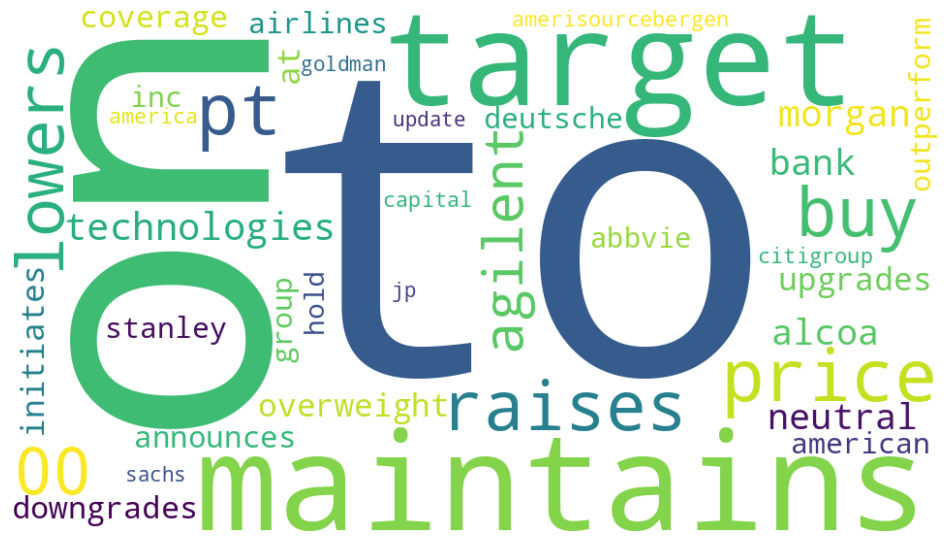

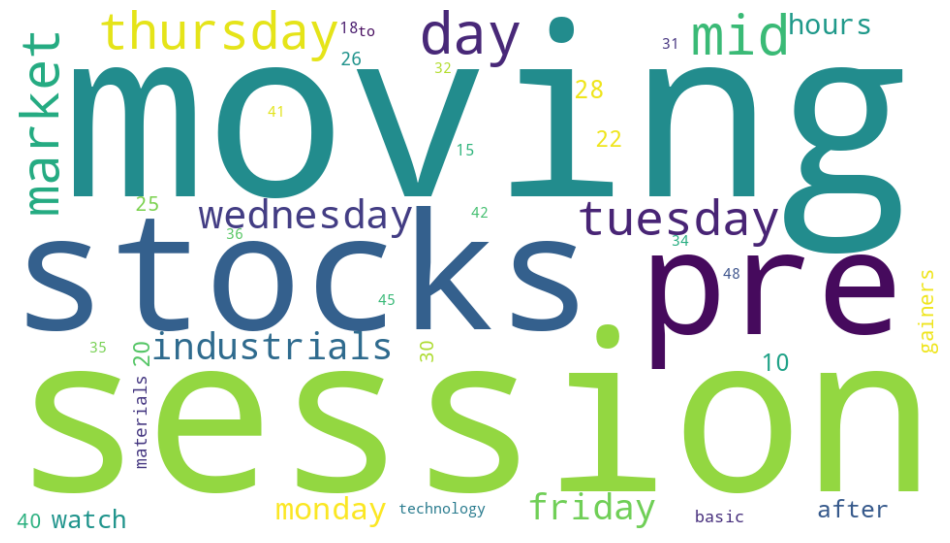

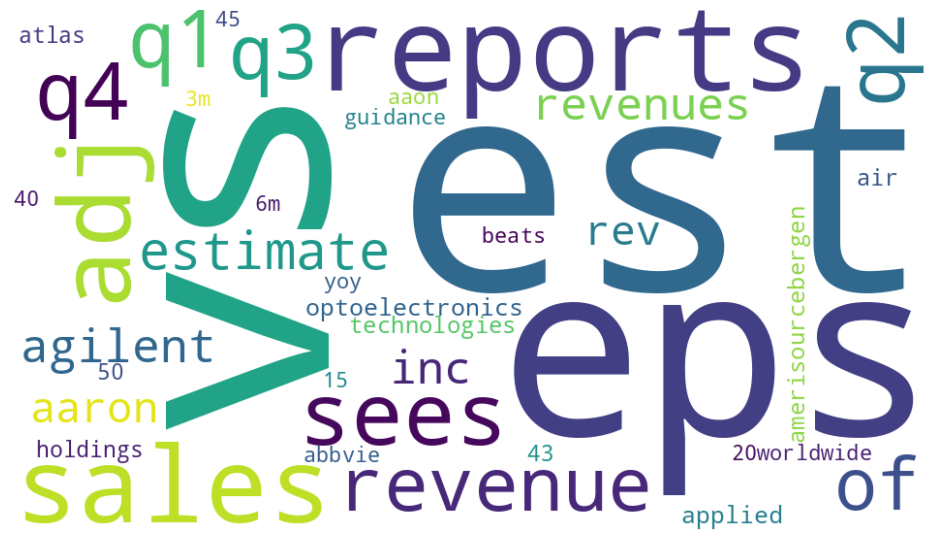

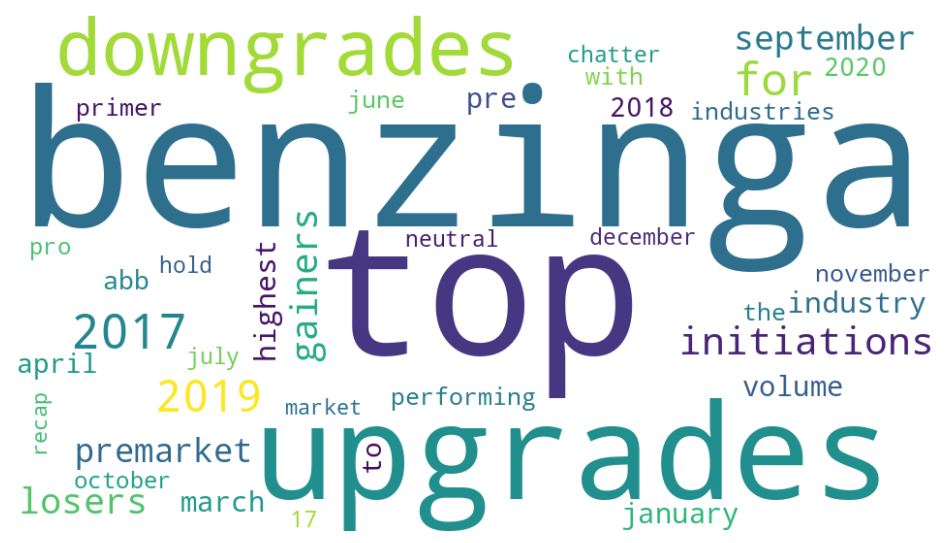

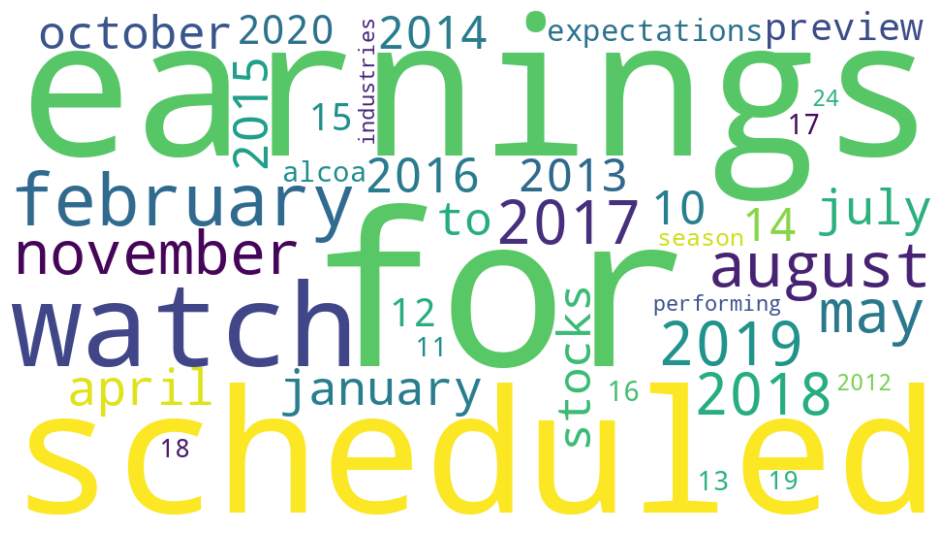

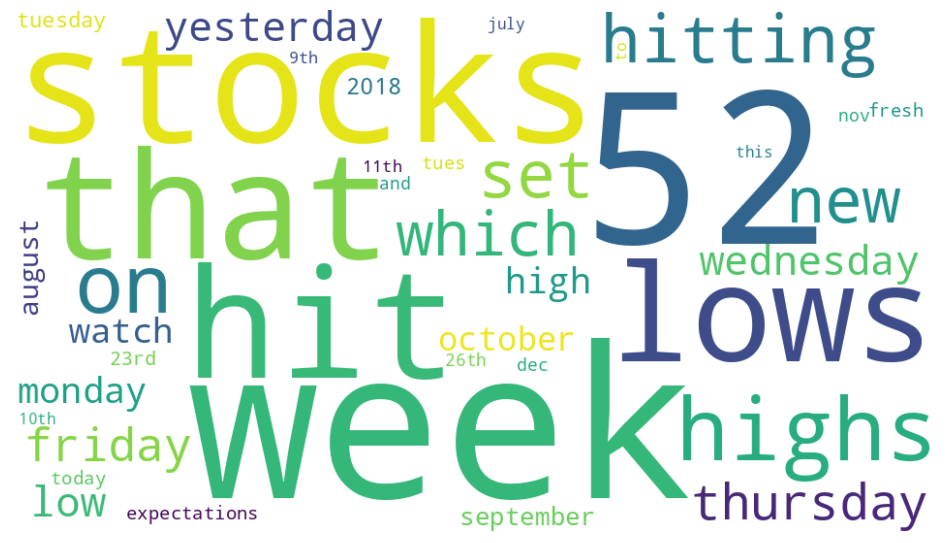

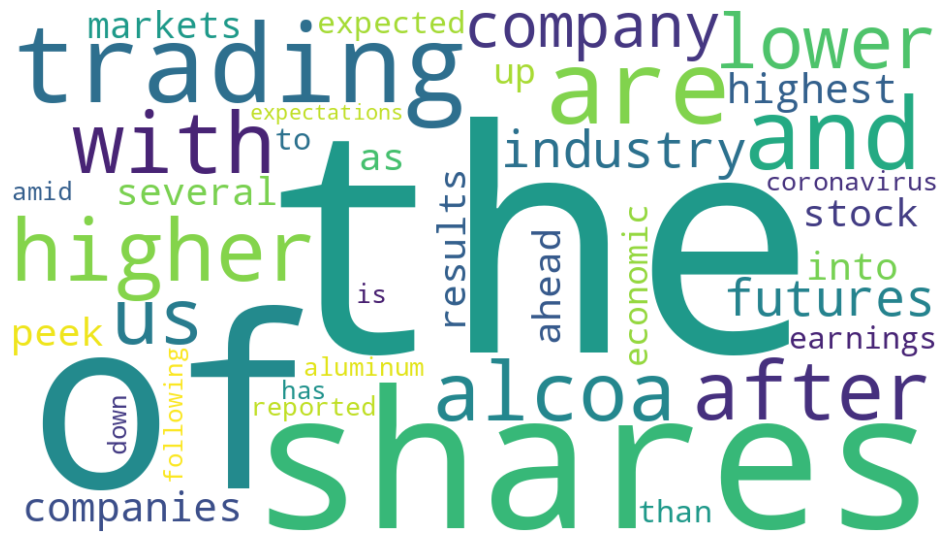

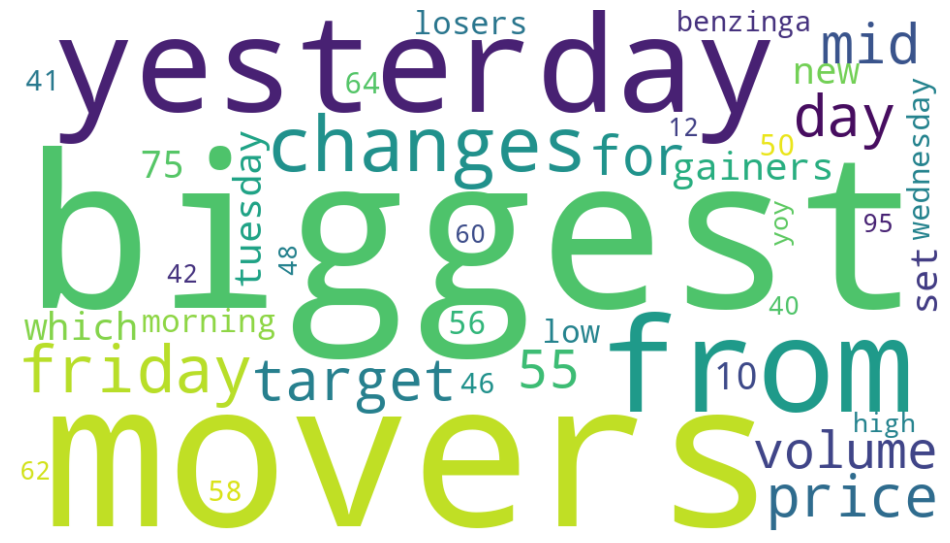

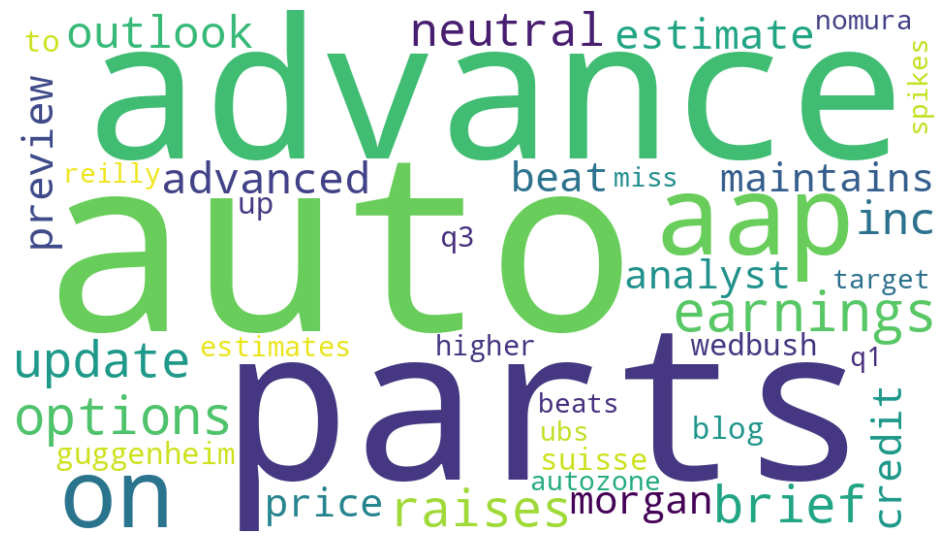

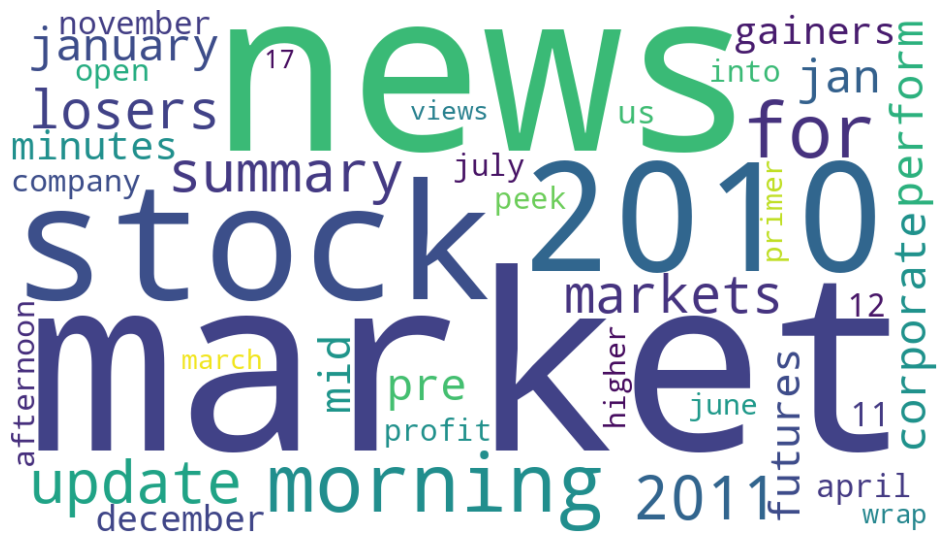

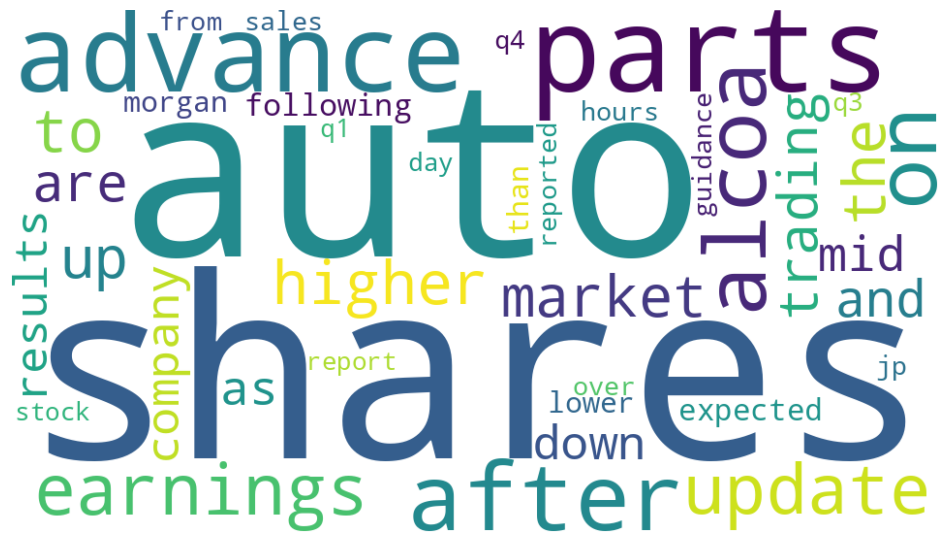

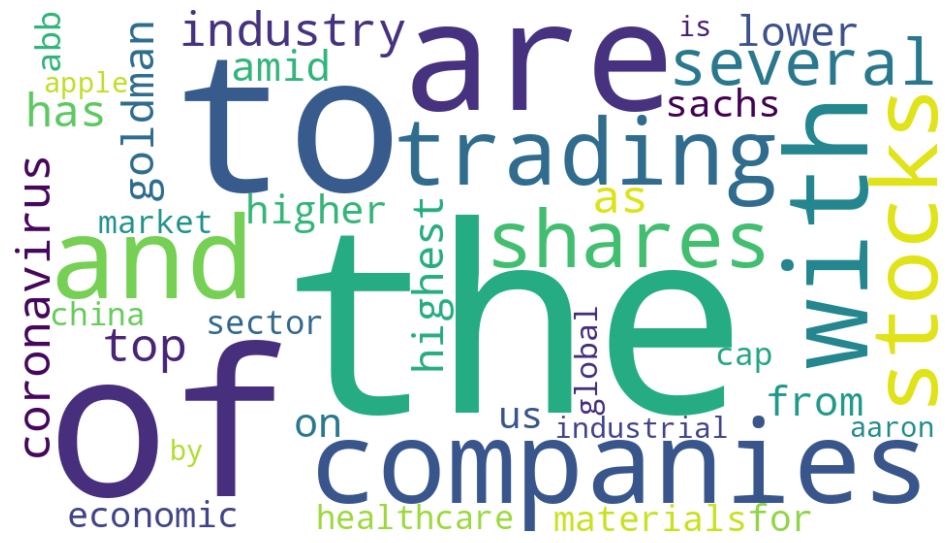

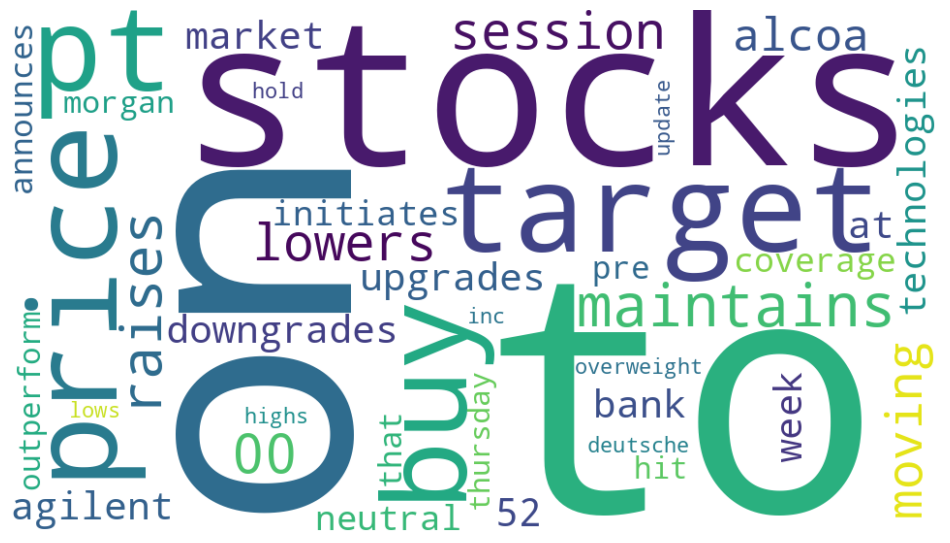

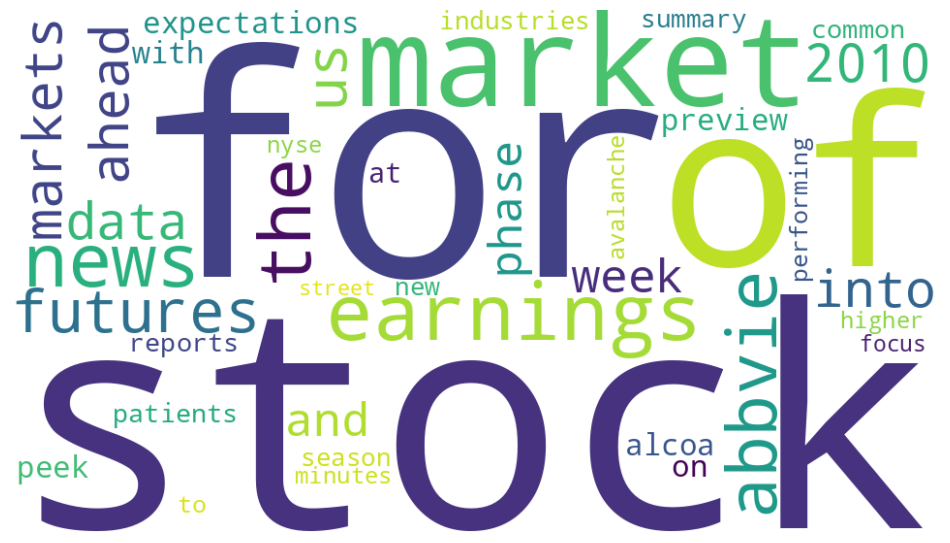

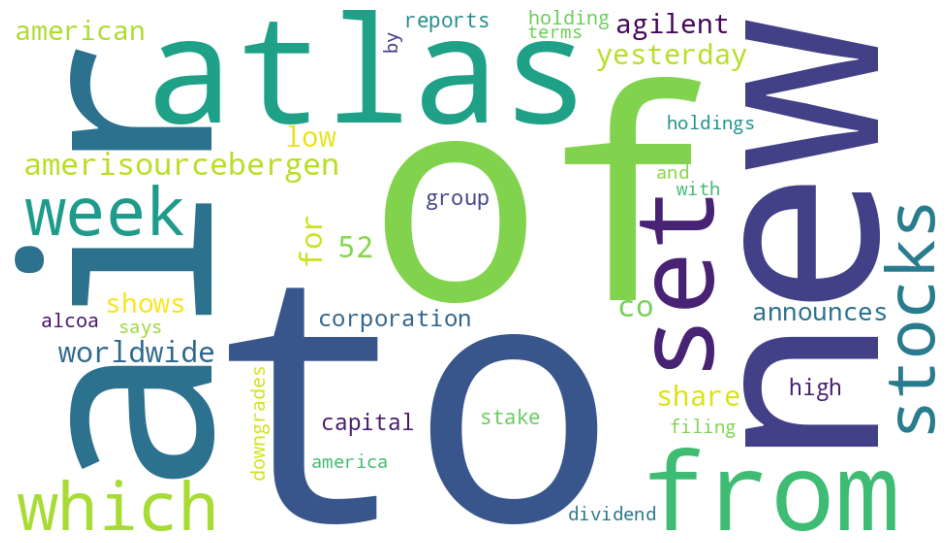

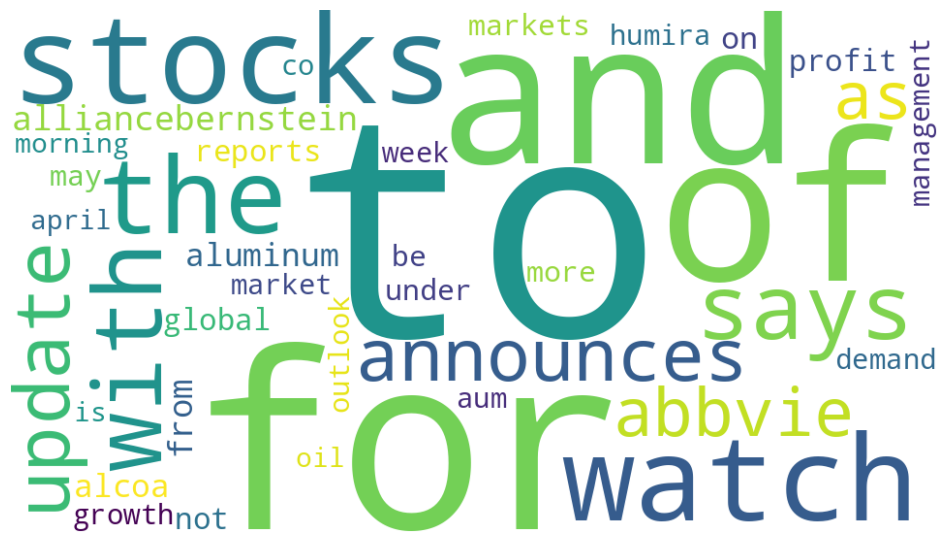

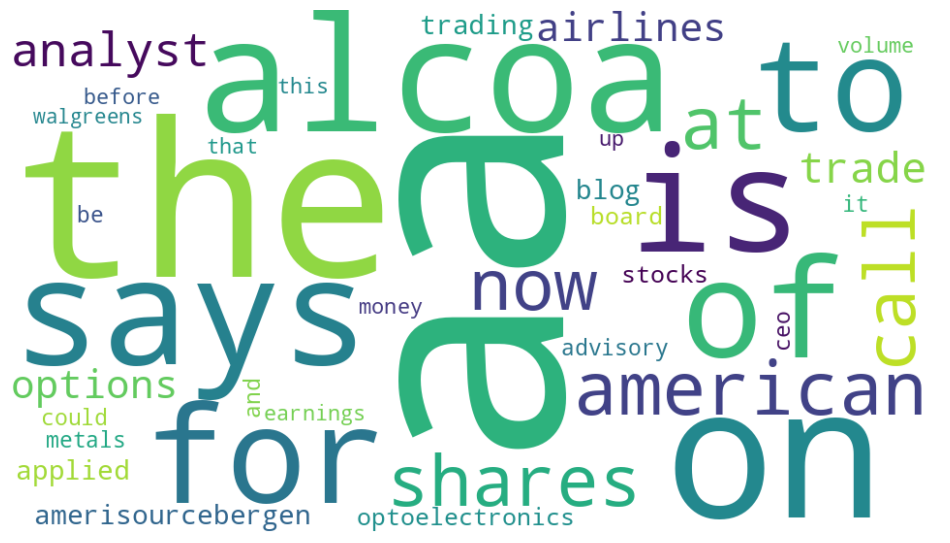

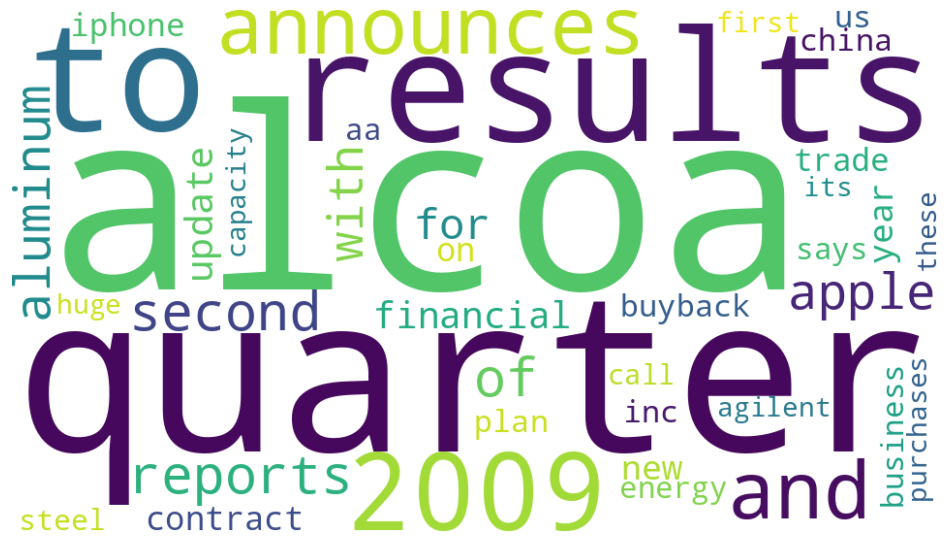

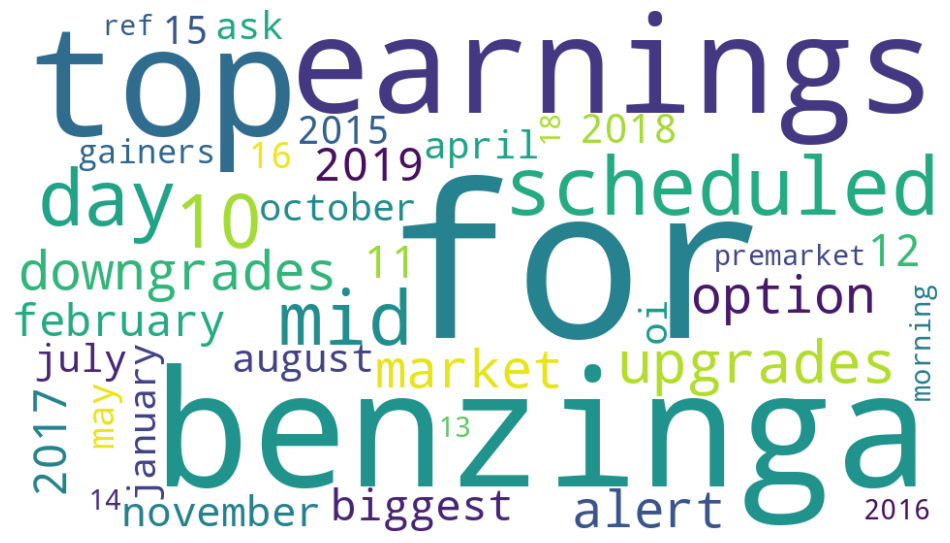

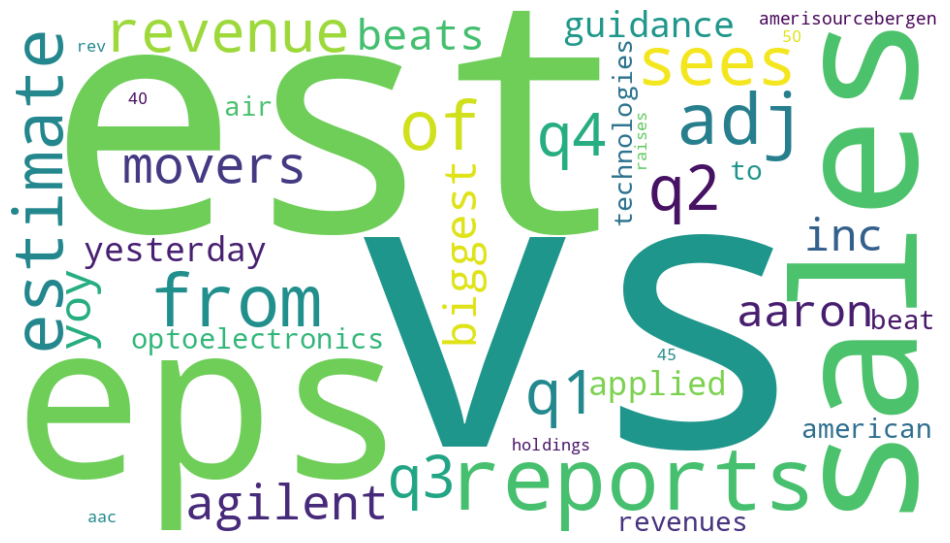

In [12]:
# import required libraries
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def wordcloud_topics (model, features, no_top_words = 40):
    for topic, words in enumerate (model.components_):
        size = {}
        largest = words.argsort ()[::-1]  # invert sort order
        for i in range (0, no_top_words):
            size [features [largest [i]]] = abs (words [largest [i]])
        wc = WordCloud (background_color = "white", max_words = 100,
                       width = 960, height = 540)
        wc.generate_from_frequencies (size)
        plt.figure (figsize = (12, 12))
        plt.imshow (wc, interpolation = 'bilinear')
        plt.axis ('off')
        
# compare NMF and LDA model
wordcloud_topics (nmf_para_model, tfidf_para_vectorizer.get_feature_names_out())
wordcloud_topics (lda_para_model, count_para_vectorizer.get_feature_names_out ())

**Building a neural network using Pytorch**

In [13]:
# import required libraries
import torch
import torch.nn as nn

x = [[2, 5], [7, 9], [4, 8], [6, 9]]
y = [[4], [9], [12], [17]]

X = torch.tensor (x).float ()
Y = torch.tensor (y).float ()

device = 'cuda' if torch.cuda.is_available () else 'cpu'
X = X.to(device)
Y = Y.to(device)

class MyNeuralNet (nn.Module):
    def __init__(self):
        super().__init__()
        self.input_to_hidden_layer = nn.Linear (2, 8)
        self.hidden_layer_activation = nn.ReLU()
        self.hidden_to_output_layer = nn.Linear (8, 1)
    def forward (self, x):
        x = self.input_to_hidden_layer (x)
        x = self.hidden_layer_activation (x)
        x = self.hidden_to_output_layer (x)
        return x
    
mynet = MyNeuralNet().to(device)
loss_func = nn.MSELoss()

_Y = mynet(X)
loss_value = loss_func (_Y, Y)
print (loss_value)

tensor(153.4856, device='cuda:0', grad_fn=<MseLossBackward0>)


Text(0, 0.5, 'loss value')

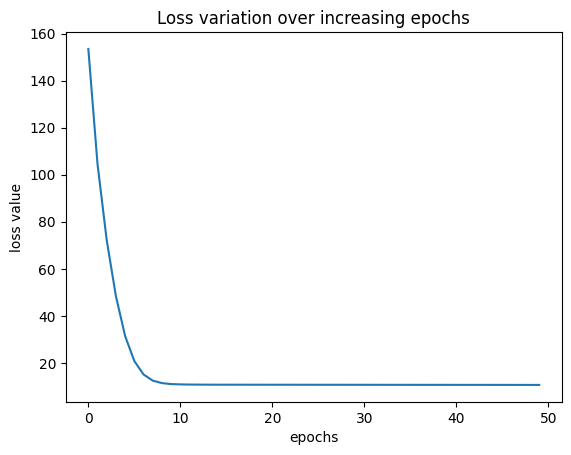

In [14]:
from torch.optim import SGD
import matplotlib.pyplot as plt
%matplotlib inline

opt = SGD (mynet.parameters(), lr = 0.001)

loss_history = []
for _ in range(50):
    opt.zero_grad()
    loss_value = loss_func (mynet (X), Y)
    loss_value.backward ()
    opt.step ()
    loss_history.append (loss_value.item())
    
plt.plot(loss_history)
plt.title ('Loss variation over increasing epochs')
plt.xlabel ('epochs')
plt.ylabel ('loss value')

**Resnet block architecture**

In [15]:
import torch
from torch import nn

class ResLayer (nn.Module):
    def __init__ (self, ni, no, kernel_size, stride=1):
        super (ResLayer, self).__init__()
        padding = kernel_size - 2
        self_conv = nn.Sequential (
        nn.Conv2d (ni, no, kernel_size, stride,
                  padding = padding),
        nn.ReLU ())
        
    def forward (self, x):
        return self.conv (x) + x

In [16]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms,models,datasets
!pip install torch_summary
from torchsummary import summary
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = models.vgg16(pretrained=True).to(device)
summary(model, torch.zeros(1,3,224,224))

  Obtaining dependency information for torch_summary from https://files.pythonhosted.org/packages/ca/db/93d18c84f73b214acfa4d18051d6f4263eee3e044c408928e8abe941a22c/torch_summary-1.4.5-py3-none-any.whl.metadata


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 262MB/s]


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        1,792
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        36,928
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       73,856
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       147,584
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         295,168
|    └─ReLU: 2-12                        [-1, 256, 56, 56]      

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        1,792
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        36,928
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       73,856
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       147,584
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         295,168
|    └─ReLU: 2-12                        [-1, 256, 56, 56]      

In [17]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1